In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('data.csv')
df.shape

(23524, 13)

In [3]:
df.groupby('gender_of_respondent').count()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,relationship_with_head,marital_status,education_level,job_type
gender_of_respondent,,,,,,,,,,,,
Female,13877,13877,13877,13877,13877,13877,13877,13877,13877,13877,13877,13877
Male,9647,9647,9647,9647,9647,9647,9647,9647,9647,9647,9647,9647


In [4]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [5]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-5-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-5-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-5-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [6]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [7]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-7-4a08e3cd5a34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-7-4a08e3cd5a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [8]:
y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
y_tr.drop(columns='bank_account',inplace=True)

<ipython-input-8-dc6323112d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['no_acc'] = np.where(y_tr['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
from sklearn.preprocessing import minmax_scale

x_tr_cont[['household_size','age_of_respondent']] = minmax_scale(x_tr_cont[['household_size','age_of_respondent']])

<ipython-input-9-d8d1fe339801>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cont[['household_size','age_of_respondent']] = minmax_scale(x_tr_cont[['household_size','age_of_respondent']])
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [10]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [11]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

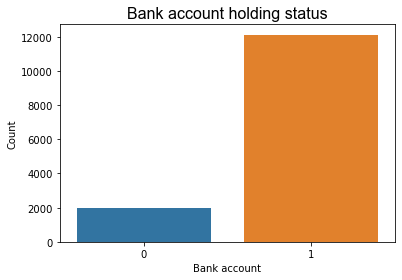

In [13]:
sns.countplot(x='no_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [14]:
count_no_acc = len(y_train[y_train['no_acc']==1])
count_acc = len(y_train[y_train['no_acc']==0])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [15]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [16]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

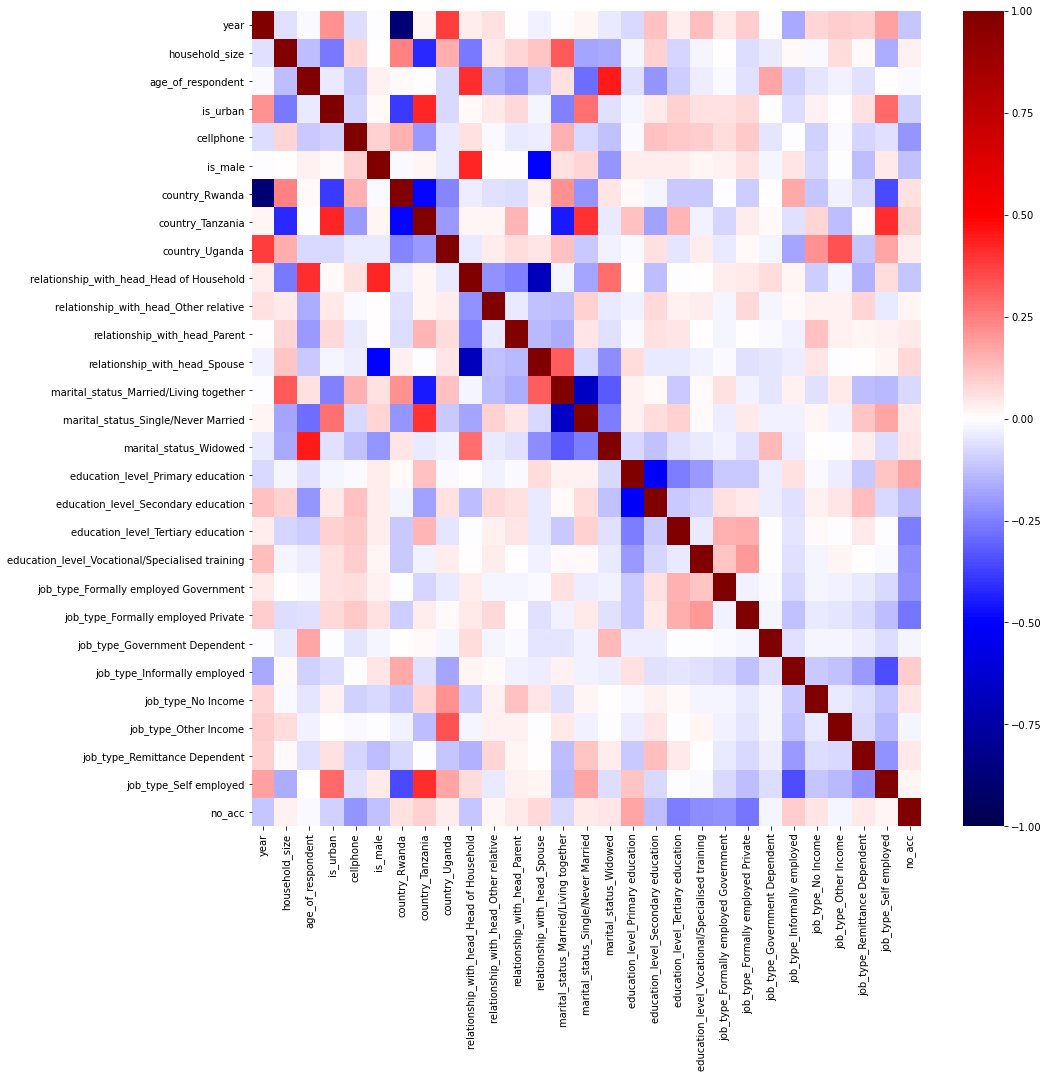

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

## Simple logistic regression

Testing with a single variable: is_male

In [18]:
#Model on is_male first
lm_1 = sm.Logit(df_train['no_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [19]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 no_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:                 0.01691
Time:                        17:10:10   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1251      0.035     60.055      0.000       2.056       2.194
is_male       -0.6779      0.049    -13.887      0.000      -0.774      -0.582
==============================================================================
"""

In [20]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['no_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [21]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  2.1251
is_male coef:  -0.6779


In [22]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['no_acc']

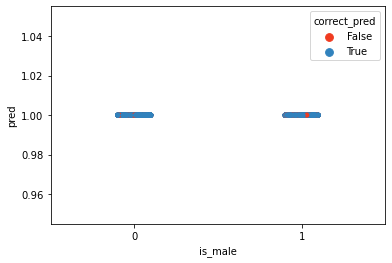

In [23]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [24]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.10668258, 0.89331742],
       [0.19044297, 0.80955703],
       [0.10668258, 0.89331742],
       [0.10668258, 0.89331742],
       [0.19044297, 0.80955703]])

In [25]:
confusion_matrix(df_eval['no_acc'], df_eval['pred'])

array([[   0,  492],
       [   0, 3037]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression
The below analysis is a multiple logistic regression for all features 

In [26]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [27]:
lm_2 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_2.fit(df_train[features], df_train['no_acc'])

preds = lm_2.predict(df_val[features])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(df_val[features], y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [28]:
print('Feature coefficient results: \n')
for feature, coef in zip(df_train[features].columns, lm_2.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

household_size : 0.000
age_of_respondent : -1.036
is_urban : -0.275
cellphone : -1.617
is_male : -0.445
country_Rwanda : 0.333
country_Tanzania : 1.249
country_Uganda : 1.185
relationship_with_head_Head of Household : -0.761
relationship_with_head_Other relative : -0.058
relationship_with_head_Parent : 0.000
relationship_with_head_Spouse : -0.521
marital_status_Married/Living together : -0.034
marital_status_Single/Never Married : 0.135
marital_status_Widowed : -0.036
education_level_Primary education : -0.708
education_level_Secondary education : -1.706
education_level_Tertiary education : -3.163
education_level_Vocational/Specialised training : -2.708
job_type_Formally employed Government : -1.582
job_type_Formally employed Private : -1.704
job_type_Government Dependent : -1.143
job_type_Informally employed : 0.368
job_type_No Income : 0.149
job_type_Other Income : -0.639
job_type_Remittance Dependent : 0.208
job_type_Self employed : -0.443


In [29]:
lm_2.intercept_

array([5.32362368])

In [30]:
df_val['preds'] = lm_2.predict(df_val[features])

In [31]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [32]:
y_prob = lm_2.predict_proba(df_val[features])

In [33]:
confusion_matrix(df_val['no_acc'], 
                 preds)

array([[ 167,  325],
       [  78, 2959]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 2954 | 83|
| **is account (1)** | 337 | 155 |

Need to understand and decide on the __trade off between recall and precision__

Precision is the number of observations predicted positive over the total actual positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the number of actually positive observations over the number predicted positive. The recall is intuitively the ability of the classifier to find all the positive samples.

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.69      3529
weighted avg       0.87      0.89      0.87      3529



In [35]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[features])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(df_val['no_acc'],
                                 df_val['proba_bank'])

In [36]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

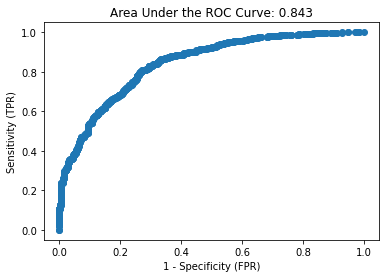

In [37]:
plot_roc(df_val['no_acc'], df_val['proba_bank'],fpr2,tpr2)

## Adjusting threshold

In [677]:
threshold = .50
y_pred = np.where((y_prob[:, 0] > threshold),0,1)

In [678]:
confusion_matrix(df_val['no_acc'], 
                 y_pred)

array([[ 167,  325],
       [  77, 2960]])

In [679]:
df_val['preds'] = np.where((y_prob[:, 0] > threshold),0,1)
df_comp = df_val[(df_val['no_acc'] != df_val['preds']) & (df_val['household_size'] ==1)]

In [680]:
pd.set_option('display.max_columns', None)

## Multiple regression removing insignificant features one by one

Based on logit summary above

## Removing parent and other relative

Based on logit summary above

In [38]:
x_train_9 = df_train.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

df_val_9 = df_val.drop(columns = ['year','relationship_with_head_Parent','relationship_with_head_Other relative'])

features9 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [39]:
lm_9 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_9.fit(x_train_9[features9], x_train_9['no_acc'])

preds9 = lm_9.predict(df_val_9[features9])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_9.score(df_val_9[features9], df_val_9['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


In [41]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_9[features9].columns, lm_9.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -1.037
household_size : 0.000
is_urban : -0.276
cellphone : -1.617
is_male : -0.445
country_Rwanda : 0.335
country_Tanzania : 1.248
country_Uganda : 1.184
relationship_with_head_Head of Household : -0.746
relationship_with_head_Spouse : -0.507
marital_status_Married/Living together : -0.033
marital_status_Single/Never Married : 0.137
marital_status_Widowed : -0.035
education_level_Primary education : -0.709
education_level_Secondary education : -1.705
education_level_Tertiary education : -3.162
education_level_Vocational/Specialised training : -2.708
job_type_Formally employed Government : -1.581
job_type_Formally employed Private : -1.707
job_type_Government Dependent : -1.143
job_type_Informally employed : 0.367
job_type_No Income : 0.150
job_type_Remittance Dependent : 0.207
job_type_Other Income : -0.638
job_type_Self employed : -0.443


In [40]:
confusion_matrix(df_val_9['no_acc'], 
                 preds9)

array([[ 168,  324],
       [  77, 2960]])

No change in recall for non-account but minor improvement in recall for account

In [42]:
print(classification_report(df_val_9['no_acc'], preds9))

              precision    recall  f1-score   support

           0       0.69      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing married / living together

In [57]:
x_train_10 = x_train_9.drop(columns='marital_status_Married/Living together')

df_val_10 = df_val_9.drop(columns='marital_status_Married/Living together')

features10 = ['age_of_respondent','household_size', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [58]:
lm_10 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_10.fit(x_train_10[features10], x_train_10['no_acc'])

preds10 = lm_10.predict(df_val_10[features10])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_10.score(
    df_val_10[features10], df_val_10['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [59]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_10[features10].columns, lm_10.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -1.040
household_size : 0.000
is_urban : -0.276
cellphone : -1.618
is_male : -0.450
country_Rwanda : 0.334
country_Tanzania : 1.257
country_Uganda : 1.184
relationship_with_head_Head of Household : -0.752
relationship_with_head_Spouse : -0.520
marital_status_Single/Never Married : 0.160
marital_status_Widowed : -0.010
education_level_Primary education : -0.709
education_level_Secondary education : -1.706
education_level_Tertiary education : -3.162
education_level_Vocational/Specialised training : -2.709
job_type_Formally employed Government : -1.581
job_type_Formally employed Private : -1.706
job_type_Government Dependent : -1.142
job_type_Informally employed : 0.368
job_type_No Income : 0.152
job_type_Remittance Dependent : 0.208
job_type_Other Income : -0.638
job_type_Self employed : -0.443


In [60]:
confusion_matrix(df_val_10['no_acc'], 
                 preds10)

array([[ 168,  324],
       [  76, 2961]])

In [61]:
print(classification_report(df_val_10['no_acc'], preds10))

              precision    recall  f1-score   support

           0       0.69      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

In [63]:
df_val_10['proba_bank'] = lm_10.predict_proba(df_val_10[features10])[:, 1]

fpr10, tpr10, thresholds10 = roc_curve(df_val_10['no_acc'],
                                 df_val_10['proba_bank'])

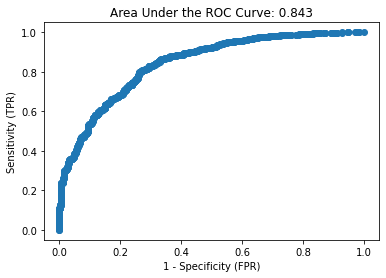

In [64]:
plot_roc(df_val_10['no_acc'], df_val_10['proba_bank'],fpr10,tpr10)

In [65]:
# calculate F1 score
f1_10 = f1_score(df_val_10['no_acc'], preds10)
print('F1 score for model 10:')
f1_10

F1 score for model 10:


0.9367288832647895

## Removing widowed

In [72]:
x_train_13 = x_train_10.drop(columns='household_size')

df_val_13 = df_val_10.drop(columns='household_size')

features13 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']

In [93]:
lm_13 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_13.fit(x_train_13[features13], x_train_13['no_acc'])

preds13 = lm_13.predict(df_val_13[features13])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_13.score(
    df_val_13[features13], df_val_13['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


In [94]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_13.columns, lm_13.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -1.041
is_urban : -0.276
cellphone : -1.618
is_male : -0.450
country_Rwanda : 0.334
country_Tanzania : 1.257
country_Uganda : 1.184
relationship_with_head_Head of Household : -0.752
relationship_with_head_Spouse : -0.520
marital_status_Single/Never Married : 0.159
marital_status_Widowed : -0.010
education_level_Primary education : -0.709
education_level_Secondary education : -1.706
education_level_Tertiary education : -3.161
education_level_Vocational/Specialised training : -2.708
job_type_Formally employed Government : -1.581
job_type_Formally employed Private : -1.706
job_type_Government Dependent : -1.142
job_type_Informally employed : 0.368
job_type_No Income : 0.152
job_type_Other Income : 0.207
job_type_Remittance Dependent : -0.638
job_type_Self employed : -0.443


In [75]:
confusion_matrix(df_val_13['no_acc'], 
                 preds13)

array([[ 168,  324],
       [  76, 2961]])

In [76]:
print(classification_report(df_val_13['no_acc'], preds13))

              precision    recall  f1-score   support

           0       0.69      0.34      0.46       492
           1       0.90      0.97      0.94      3037

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [77]:
df_val_13['proba_bank'] = lm_13.predict_proba(df_val_13[features13])[:, 1]

fpr13, tpr13, thresholds13 = roc_curve(df_val_13['no_acc'],
                                 df_val_13['proba_bank'])

In [78]:
df_val_13['preds'] = lm_13.predict(df_val_13[features13])
df_check = df_val_13[(df_val_13['no_acc'] != df_val_13['preds']) & (df_val_13['proba_bank'] >= 0.65)]

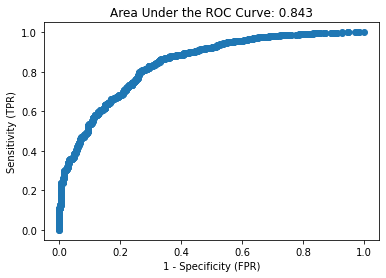

In [79]:
plot_roc(df_val_13['no_acc'], df_val_13['proba_bank'],fpr13,tpr13)
#plt.savefig("roc13.svg")

In [80]:
# calculate F1 score
f1_13 = f1_score(df_val_13['no_acc'], preds13)
print('F1 score for non bank account holiders in model 13:')
f1_13

F1 score for non bank account holiders in model 13:


0.9367288832647895

In [81]:
precision13, recall13, thresholds_13 = precision_recall_curve(df_val_13['no_acc'], df_val_13['proba_bank'])

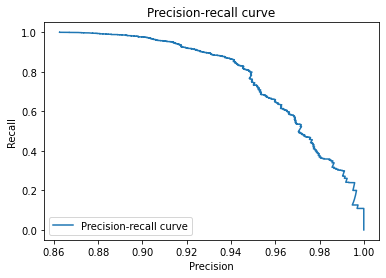

In [82]:
plt.plot(precision13, recall13, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")

In [83]:
auc13 = auc(recall13,precision13)
auc13

0.9676613161473769

NOTE THIS DOES NOT LOOK CONSISTENT WITH THE FIGURE ABOVE 

In [84]:
rw_wrong = len(df_check[df_check['country_Rwanda']==1]) / len(df_check)
tz_wrong = len(df_check[df_check['country_Tanzania']==1]) / len(df_check)
ug_wrong = len(df_check[df_check['country_Uganda']==1]) / len(df_check)
ke_wrong = 1 - rw_wrong - tz_wrong - ug_wrong
print("Rwanda wrong:{:0.3f} \nTanzania wrong: {:0.3f} \nUganda wrong:{:0.3f} \nKenya wrong:{:0.3f}".format(rw_wrong,tz_wrong,ug_wrong,ke_wrong))

Rwanda wrong:0.375 
Tanzania wrong: 0.242 
Uganda wrong:0.048 
Kenya wrong:0.335


The majority of the highly confident, incorrect predictions are in Rwanda (37%) and Kenya (33%)

## Just females

In [86]:
x_train_15 = x_train_13[x_train_13['is_male']==0]

df_val_15 = df_val_13[df_val_13['is_male']==0]

x_train_15 = x_train_15.drop(columns='is_male',axis=1)
df_val_15 = df_val_15.drop(columns='is_male',axis=1)

features15 =['age_of_respondent', 'is_urban', 'cellphone',
       'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']


In [87]:
lm_15 = LogisticRegression(C=1,penalty='l1',solver='liblinear')
lm_15.fit(x_train_15[features15], x_train_15['no_acc'])

preds15 = lm_15.predict(df_val_15[features15])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_15.score(
    df_val_15[features15], df_val_15['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.913


In [88]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_15.columns, lm_15.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -1.338
is_urban : -0.268
cellphone : -1.600
country_Rwanda : 0.476
country_Tanzania : 1.237
country_Uganda : 1.187
relationship_with_head_Head of Household : -0.401
relationship_with_head_Spouse : -0.371
marital_status_Single/Never Married : 0.215
marital_status_Widowed : -0.224
education_level_Primary education : -0.627
education_level_Secondary education : -1.683
education_level_Tertiary education : -3.249
education_level_Vocational/Specialised training : -2.444
job_type_Formally employed Government : -1.745
job_type_Formally employed Private : -2.037
job_type_Government Dependent : -0.662
job_type_Informally employed : 0.203
job_type_No Income : 0.265
job_type_Other Income : 0.000
job_type_Remittance Dependent : -0.923
job_type_Self employed : -0.609


In [89]:
confusion_matrix(df_val_15['no_acc'], 
                 preds15)

array([[  51,  161],
       [  19, 1838]])

In [90]:
print(classification_report(df_val_15['no_acc'], preds15))

              precision    recall  f1-score   support

           0       0.73      0.24      0.36       212
           1       0.92      0.99      0.95      1857

    accuracy                           0.91      2069
   macro avg       0.82      0.62      0.66      2069
weighted avg       0.90      0.91      0.89      2069



## Just males

In [95]:
x_train_16 = x_train_13[x_train_13['is_male']==1]

df_val_16 = df_val_13[df_val_13['is_male']==1]

x_train_16 = x_train_16.drop(columns='is_male',axis=1)
df_val_16 = df_val_16.drop(columns='is_male',axis=1)

features16 =['age_of_respondent', 'is_urban', 'cellphone',
       'country_Rwanda', 'country_Tanzania', 'country_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse', 
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent','job_type_Other Income','job_type_Self employed']


In [96]:
lm_16 = LogisticRegression(penalty='l2')
lm_16.fit(x_train_16[features16], x_train_16['no_acc'])

preds16 = lm_16.predict(df_val_16[features16])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(lm_16.score(
    df_val_16[features16], df_val_16['no_acc'])))

Accuracy of logistic regression classifier on val set: 0.847


In [97]:
print('Feature coefficient results: \n')
for feature, coef in zip(x_train_16.columns, lm_16.coef_.reshape(1, -1)[0]):
        print(feature, ':', f'{coef:.3f}')

Feature coefficient results: 

age_of_respondent : -0.708
is_urban : -0.291
cellphone : -1.608
country_Rwanda : 0.281
country_Tanzania : 1.311
country_Uganda : 1.216
relationship_with_head_Head of Household : -0.986
relationship_with_head_Spouse : -0.280
marital_status_Single/Never Married : 0.038
marital_status_Widowed : 0.238
education_level_Primary education : -0.583
education_level_Secondary education : -1.549
education_level_Tertiary education : -2.816
education_level_Vocational/Specialised training : -2.753
job_type_Formally employed Government : -1.385
job_type_Formally employed Private : -1.421
job_type_Government Dependent : -1.535
job_type_Informally employed : 0.514
job_type_No Income : -0.205
job_type_Other Income : 0.608
job_type_Remittance Dependent : -0.355
job_type_Self employed : -0.286


In [98]:
confusion_matrix(df_val_16['no_acc'], 
                 preds16)

array([[ 113,  167],
       [  56, 1124]])

In [99]:
print(classification_report(df_val_16['no_acc'], preds16))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50       280
           1       0.87      0.95      0.91      1180

    accuracy                           0.85      1460
   macro avg       0.77      0.68      0.71      1460
weighted avg       0.83      0.85      0.83      1460



## Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

## 1. Preparing the test sample 

In [100]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-100-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-100-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-100-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [101]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [102]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-102-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-102-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [103]:
x_test_cont[['household_size','age_of_respondent']] = minmax_scale(x_test_cont[['household_size','age_of_respondent']])

<ipython-input-103-39dd1fc91703>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cont[['household_size','age_of_respondent']] = minmax_scale(x_test_cont[['household_size','age_of_respondent']])
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [104]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['country',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [105]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [106]:
y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-106-41dba9f5dd1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['no_acc'] = np.where(y_test['bank_account'] == 'No', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Testing the model on the test sample

## Model 1 - all features

In [122]:
preds1_test = lm_2.predict(df_test[features])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_2.score(df_test[features], df_test['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.885


In [123]:
confusion_matrix(df_test['no_acc'], 
                 preds1_test)

array([[ 294,  540],
       [ 138, 4909]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 4909 | 138|
| **is account (1)** | 540 | 294 |

Need to do the following:
* Check error metrics
* Conduct cross validation
* Test with other classification models 

In [124]:
print(classification_report(df_test['no_acc'], preds1_test))

              precision    recall  f1-score   support

           0       0.68      0.35      0.46       834
           1       0.90      0.97      0.94      5047

    accuracy                           0.88      5881
   macro avg       0.79      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



## Multiple regression with model 13

In [109]:
df_test_13

,household_size,is_urban,cellphone,is_male,country_Rwanda,country_Tanzania,country_Uganda,relationship_with_head_Head of Household,relationship_with_head_Other relative,relationship_with_head_Parent,...,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Remittance Dependent,no_acc
16628,0.157895,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
12261,0.315789,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1101,0.105263,1,1,1,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
20899,0.000000,0,1,1,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7521,0.210526,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13695,0.210526,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
10203,0.052632,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8271,0.157895,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4371,0.157895,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [110]:
df_test_13 = df_test.drop(columns= ['year','household_size','relationship_with_head_Other relative',
                                   'relationship_with_head_Parent'])

In [111]:
preds13_test = lm_13.predict(df_test_13[features13])
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(
    lm_13.score(df_test_13[features13],df_test_13['no_acc'])))

Accuracy of logistic regression classifier on test set: 0.883


In [112]:
confusion_matrix(df_test_13['no_acc'], 
                 preds13_test)

array([[ 290,  544],
       [ 143, 4904]])

In [113]:
print(classification_report(df_test_13['no_acc'], preds13_test))

              precision    recall  f1-score   support

           0       0.67      0.35      0.46       834
           1       0.90      0.97      0.93      5047

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



Model is broadly consistent across train - val - test

In [114]:
df_test_13['proba_bank'] = lm_13.predict_proba(df_test_13[features13])[:, 1]

fpr13_test, tpr13_test, thresholds13_test = roc_curve(df_test_13['no_acc'],
                                 df_test_13['proba_bank'])

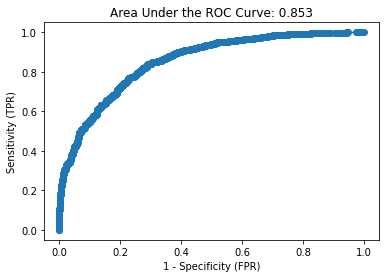

In [115]:
plot_roc(df_test_13['no_acc'], df_test_13['proba_bank'],fpr13_test,tpr13_test)

In [116]:
# calculate F1 score
f1_13_test = f1_score(df_test_13['no_acc'], preds13_test)
print('F1 score for bank account holiders in model 13:')
f1_13_test

F1 score for bank account holiders in model 13:


0.9345402572653644